## Notebook to illustrate how the probablistic jerk finder works.

#### Here is an assumed underlying piecewise linear time dependence with a change in slope at t=50.5:

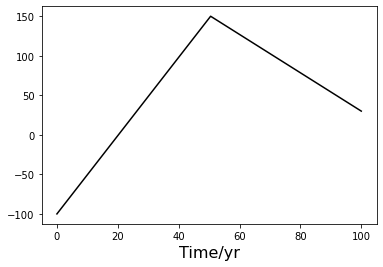

In [1]:
import matplotlib.pyplot as plt
import numpy as np
time_for_plotting = np.linspace(0,100,100,endpoint=True)
plt.figure()
plt.plot([0,50.5,100],[-100,150,30],'k');
plt.xlabel('Time/yr',fontsize=16)
plt.savefig('example1_raw_signal.pdf',bbox_inches='tight')

#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

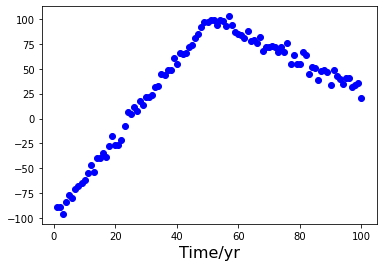

In [2]:
plt.figure()
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(1,100,NUM_DATA,dtype=float)
delta_Y = 5 * np.ones(NUM_DATA)
Y = np.interp(TIMES,[0,50.5,100],[-100,100,30]) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time/yr',fontsize=16)
plt.savefig('example1_noised_signal.pdf',bbox_inches='tight')

In [12]:
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200
discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 100
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in
CP_NBINS = 100  #collect change point histogram over 100 bins for the 100 time units

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist = np.zeros( CP_NBINS,dtype=int )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, cp_nbins = CP_NBINS,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[14.85910034  7.63339663  1.57270801  1.57433379]


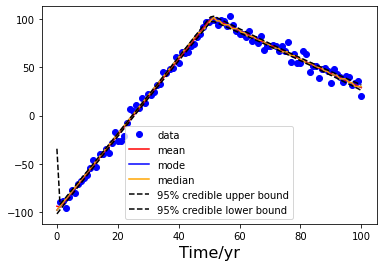

In [13]:
plt.figure()
plt.plot(TIMES,Y,'bo', label='data')
plt.plot(time_for_plotting,AV,'r', label='mean')
plt.plot(time_for_plotting,MODE, 'b',  label='mode')
plt.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
plt.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
plt.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
plt.legend(loc='lower center')
plt.xlabel('Time/yr',fontsize=16)
plt.savefig('example1_posterior.pdf',bbox_inches='tight')

#### Histogram of vertex probability with original time series. The vertical scale indicates the probability that an internal vertex is in each (1 time unit) bin:

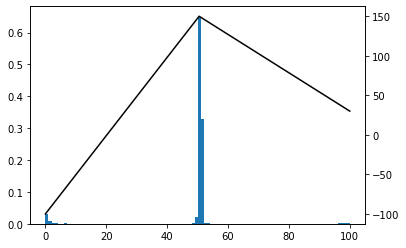

In [14]:
# Binning in code:
# bins are 0-1, 1-2, 2-3, 3-4, etc. with left edges at 0,1,2,3,4,...
# 
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = np.linspace(TIMES_MIN, TIMES_MAX, CP_NBINS,endpoint=False)
ax = plt.gca()
plt.bar(left_edges, CP_hist/fac, align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2 = ax.twinx()
plt.plot([0,50.5,100],[-100,150,30],'k');
plt.xlabel('Time/yr',fontsize=16)
plt.xlabel('Probability of change in slope',fontsize=16)
plt.savefig('example1_jerk_timing.pdf',bbox_inches='tight')

In [13]:
from scipy.signal import find_peaks
peaks,_ = find_peaks(CP_hist/fac, height=0.1)
print('Most probable change in slope is between {0:f} and {1:f}'.format(left_edges[peaks][0], left_edges[peaks+1][0]))

Most probable change in slope is between 50.000000 and 51.000000
